# P. taeda model, ages and transit time calculations and simulations 

The objective of this notebook is to describe and make available all the code used to get the results for P. taeda presented in the manuscript "Non-structural carbon ages and transit times provide insights in carbon allocation dynamics of mature trees". 

1. we loaded all the dependencies for the code to run. 
   
Sometimes packages changes. You may need to check for functional changes in the packages listed below and adapt the code if necessary. 

In [1]:
from CompartmentalSystems.smooth_reservoir_model import SmoothReservoirModel
from CompartmentalSystems.smooth_model_run import SmoothModelRun 
from CompartmentalSystems.start_distributions import start_age_distributions_from_steady_state,start_age_moments_from_steady_state
from sympy import Symbol, symbols, Function
from plotly.offline import plot
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

2. We satated the names of the fluxes and state variables. Then the function f_expr is created to introduce the simulations, which consisted in runing the model in steady state for 10 years and then cut all the incomes to cero. 

In [2]:
E, FSNSC, FANSC, FB = symbols('E FSNSC FANSC FB') 
SANSC, SSNSC, SB =symbols('SANSC SSNSC SB')
BRANSC, BRB =symbols('BRANSC BRB')
RANSC, RSNSC, RB =symbols('RANSC RSNSC RB')
FL, Rm, Lf, Cf, Sf,Gf = symbols('FL Rm Lf Cf Sf Gf')
BRL, SL, Ss, Gs, Sbr, Gbr, Cs, Lbr, LSs =symbols('BRL SL Ss Gs Sbr Gbr Cs Lbr LSs')
RL, Sr, Cr, Gr, Lr =symbols('RL Sr Cr Gr Lr')
state_vector = [E, FANSC, FSNSC, BRANSC, SANSC, SSNSC, RANSC, RSNSC]
t = Symbol('t')

f_expr = Function('f')(t)

def f_step(t):
    t_step=10
    val=200090 if t<t_step else 0
    return val

func_set_step = {f_expr: f_step}


#input_fluxes = {0: FANSC*f_expr+2} 
input_fluxes = {0: f_expr} 
output_fluxes = {
    0:Rm*E,
    1:Gf*FANSC,
    3:Gbr*BRANSC,
    4:Gs*SANSC,
    5:LSs*SSNSC,
    6:Gr*RANSC
    }

internal_fluxes = {
    (0,1):FL*E,
    (0,3):BRL*E,
    (0,4):SL*E,
    (0,6):RL*E,
    (1,2):Sf*FANSC,
    (2,0):Cf*FSNSC,
    (3,5):Sbr*BRANSC,
    (4,5):Ss*SANSC,
    (5,0):Cs*SSNSC,
    (6,7):Sr*RANSC,
    (7,0):Cr*RSNSC
    }


3. The smooth reservoir model (srm) should be build using the fluxes and state vector described before and introducine the values to the parametes and define time 0. The values of the parametes are given in the table 1 of the manuscript and the code that was used to calculated them is named "P.taeda_parameter_sensitivy_and_uncertainty_analysis.R"

In [3]:
srm = SmoothReservoirModel(state_vector, t, input_fluxes, output_fluxes, internal_fluxes)
t0=0
parameter_set={
        Rm:0.1667,
        FL:0.0416, 
        Cf:0.333,  
        Sf:0.0679, 
        Gf:0.9320,
        BRL:0.7565,
        Sbr:0.0566,
        Gbr:0.9433,
        SL:0.000062,
        Cs:0.0229,
        Ss:0.0566,
        Gs:0.9433,
        LSs:0.0601,
        RL:0.0348,
        Sr:0.0579,
        Cr:0.5,
        Gr:0.9420, 
        }

4.  The start age distributions (distributions in steady state) are computed here

In [4]:
a_dens_function,x_fix = start_age_distributions_from_steady_state(
    srm,
    t0=t0,
    parameter_dict=parameter_set,
    func_set=func_set_step
)
print("fixpoint", x_fix)
# create a model run that starts at x_fix and t0
times = np.linspace(t0,50,50)
smr = SmoothModelRun(srm, parameter_dict=parameter_set, start_values=x_fix, times=times,func_set=func_set_step)


############################################
in function: lapm_for_steady_state
x_fix = [2.03549074e+05 8.46848831e+03 1.72675783e+03 1.54000274e+05
 1.26213047e+01 1.05025661e+05 7.08421619e+03 8.20352234e+02]
 type: <class 'numpy.ndarray'>
############################################
############################################
in function: lapm_for_steady_state
B0 = [[-9.99662e-01  0.00000e+00  3.33000e-01  0.00000e+00  0.00000e+00
   2.29000e-02  0.00000e+00  5.00000e-01]
 [ 4.16000e-02 -9.99900e-01  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  6.79000e-02 -3.33000e-01  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.56500e-01  0.00000e+00  0.00000e+00 -9.99900e-01  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.20000e-05  0.00000e+00  0.00000e+00  0.00000e+00 -9.99900e-01
   0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  5.66000e-02  5.66000e-02
  -8.30000e-02  

5. We constructed a function p that takes an age array "ages: as argument and give back a three dimensional ndarray (ages x times x pools) from the a array-value function of a single age a_dens_function". Ages specify the amount of times the model is ran (start_year, end_year, number_of_points). Then, we ran our function p along the age vector and extract the system age density distribution (system_dens_data).

In [5]:
p=smr.pool_age_densities_func(a_dens_function)
ages=np.linspace(0,50,200)
pool_dens_data=p(ages)
system_dens_data=smr.system_age_density(pool_dens_data)

100%|██████████| 200/200 [05:21<00:00,  2.91s/it]


6. The mean age for each time steps and each pool is clcualted in start_mean_ages

In [6]:
start_mean_ages=start_age_moments_from_steady_state(
    srm,
    t0=t0,
    parameter_dict=parameter_set,
    func_set=func_set_step,
    max_order=1
)

############################################
in function: lapm_for_steady_state
x_fix = [2.03549074e+05 8.46848831e+03 1.72675783e+03 1.54000274e+05
 1.26213047e+01 1.05025661e+05 7.08421619e+03 8.20352234e+02]
 type: <class 'numpy.ndarray'>
############################################
############################################
in function: lapm_for_steady_state
B0 = [[-9.99662e-01  0.00000e+00  3.33000e-01  0.00000e+00  0.00000e+00
   2.29000e-02  0.00000e+00  5.00000e-01]
 [ 4.16000e-02 -9.99900e-01  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  6.79000e-02 -3.33000e-01  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.56500e-01  0.00000e+00  0.00000e+00 -9.99900e-01  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.20000e-05  0.00000e+00  0.00000e+00  0.00000e+00 -9.99900e-01
   0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  5.66000e-02  5.66000e-02
  -8.30000e-02  

7. The system mean age for each time step of the model run is calculated in mean_sys_age. The mean system age for the steady state is shown in the first 10 time steps, we choose the time 1 here to show the value of the mean age in steady state. 

In [7]:
mean_sys_age=smr.system_age_moment(1, start_mean_ages)
mean_sys_age[1]

4.415003058891906

8. We ploted the system density distribution of the NSC given by system_dens_data and the density distribution of each NSC pool given by pool_dens_data. For making this plot it was necesary to import a new dependency "Subplot". This is one of the figures of Figure 3 in the manuscript.

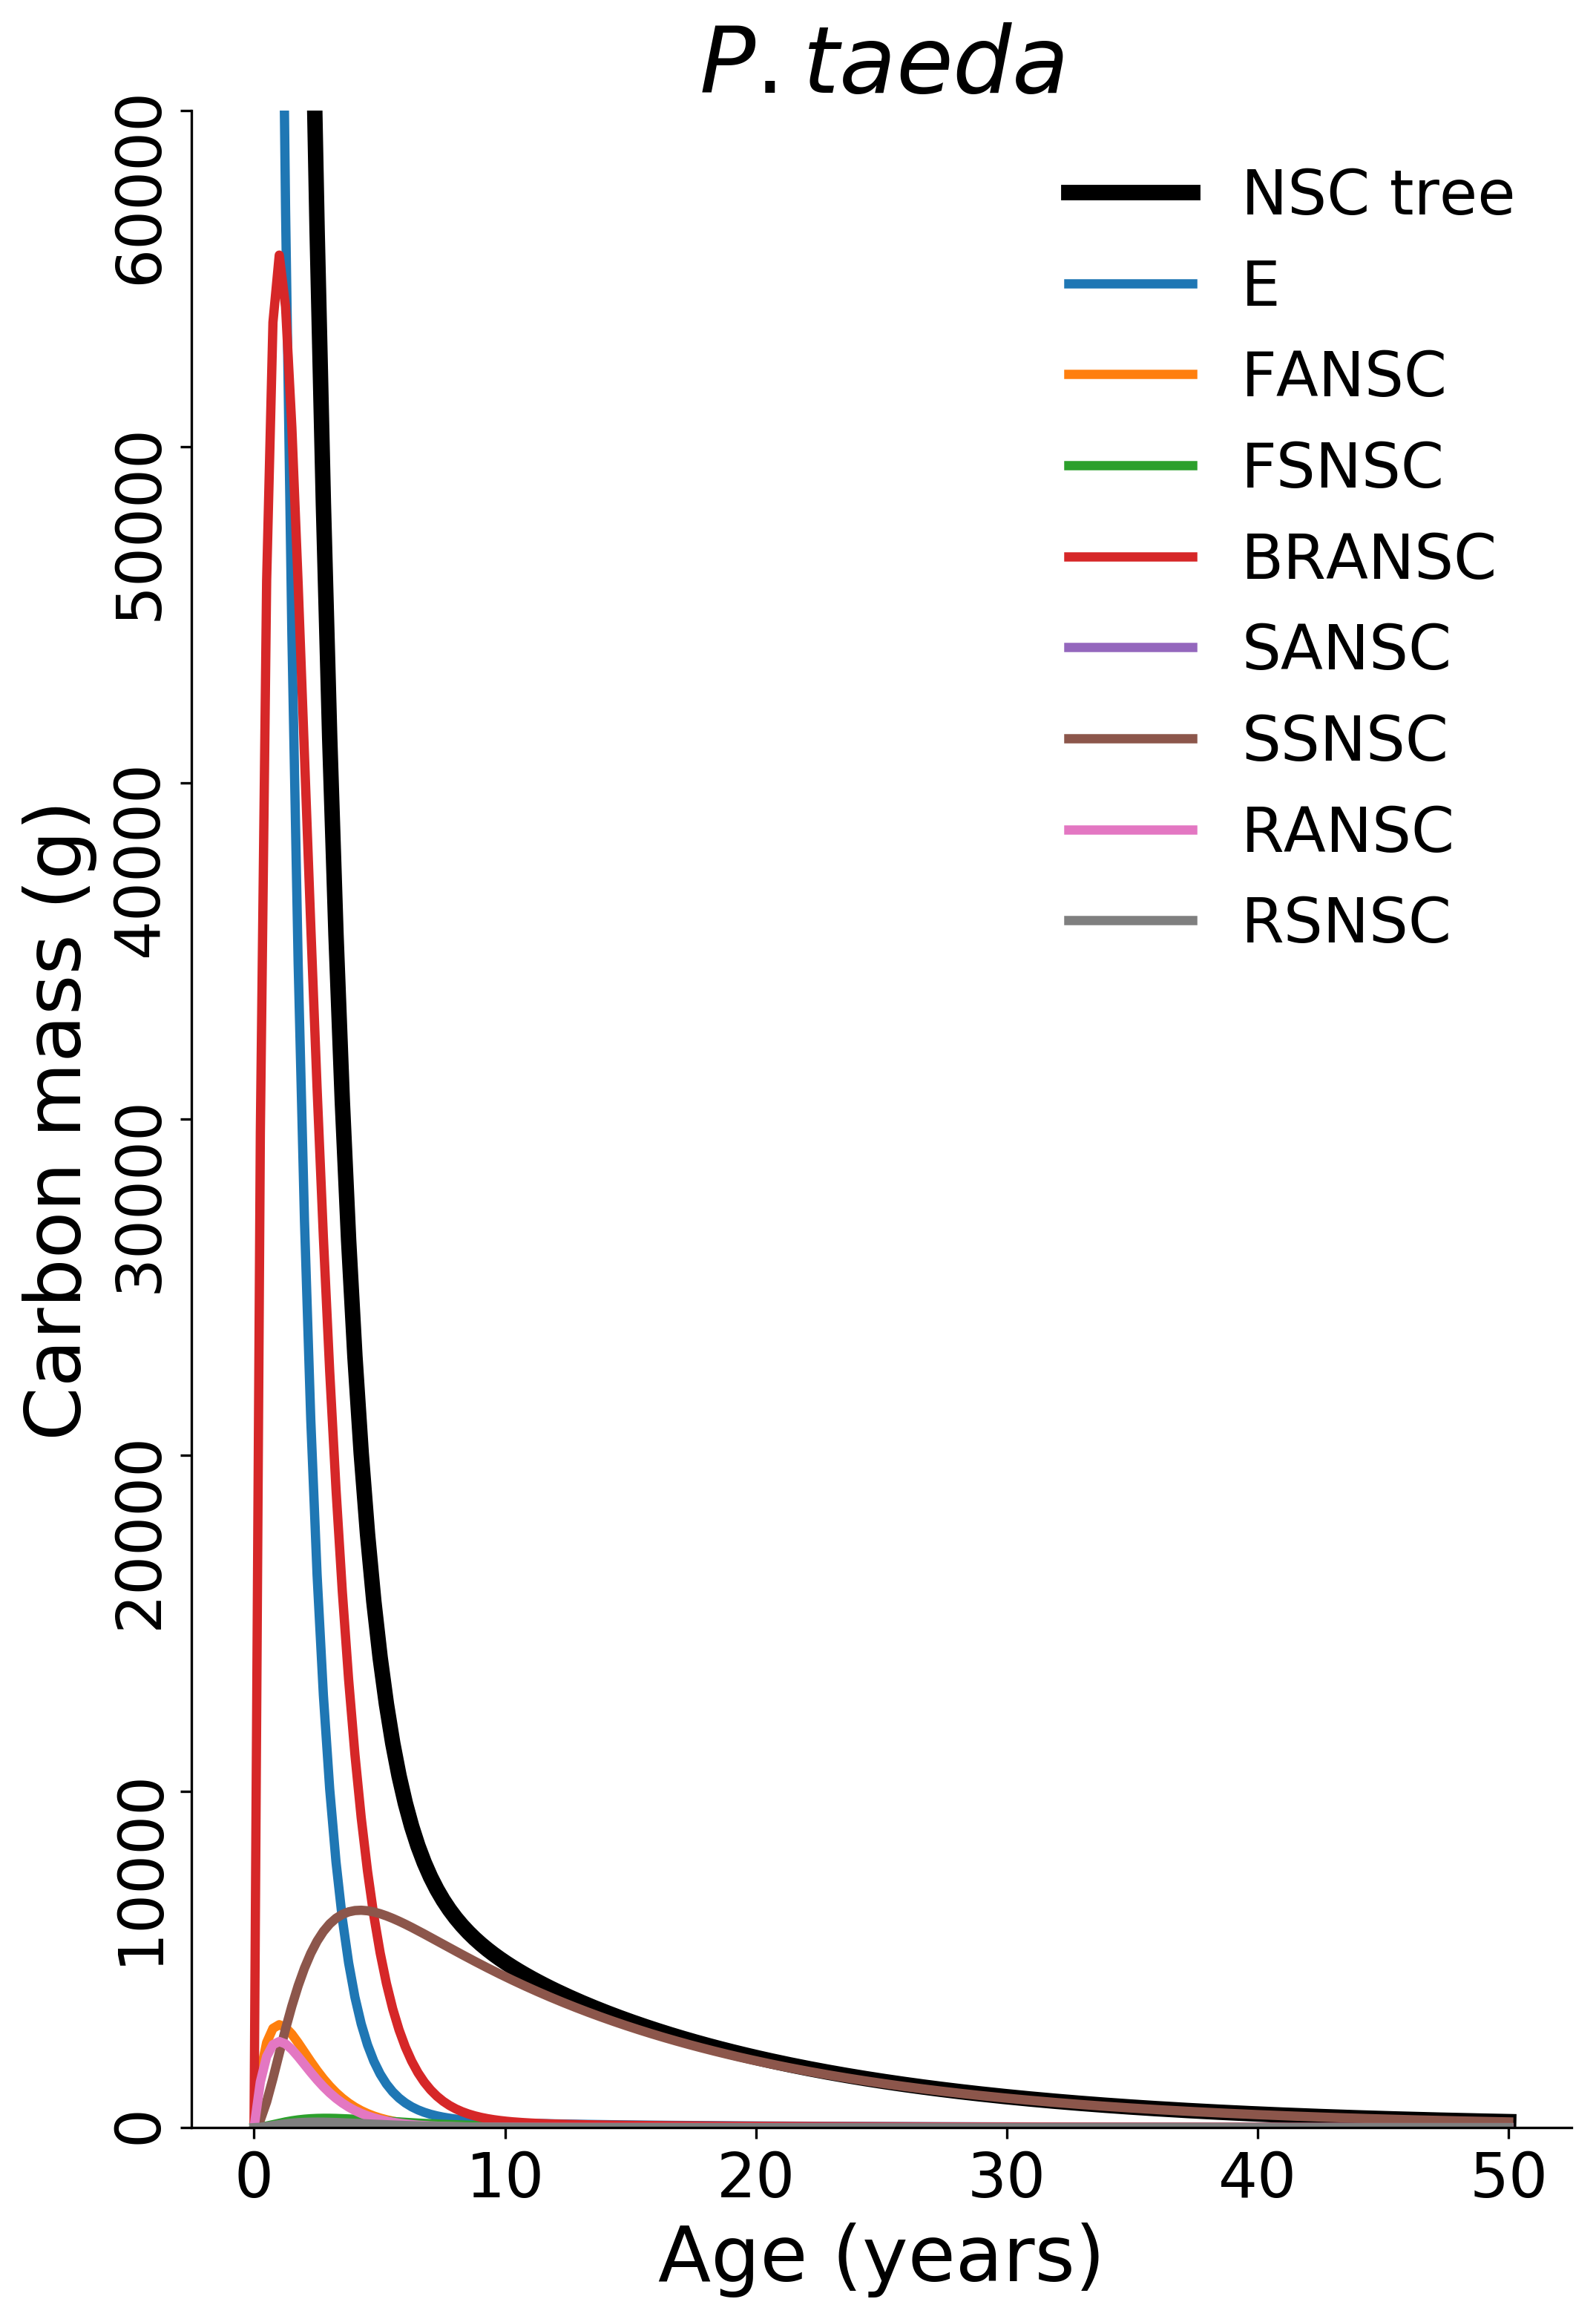

In [8]:
from mpl_toolkits.axisartist.axislines import Subplot
fig=plt.figure(figsize=(8,12), dpi=300)
ax=plt.subplot()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.plot(ages, system_dens_data[:,1], color="black", linewidth=5)
ax.plot(ages, pool_dens_data[:,1,:], linewidth=3)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.yticks(rotation=90)
plt.xlabel('Age (years)', fontsize=25)
plt.ylabel('Carbon mass (g)',fontsize=25)
plt.ylim(0,60000)
plt.title('$\it{P.taeda}$', fontsize=30)
plt.legend(["NSC tree","E","FANSC","FSNSC", "BRANSC", "SANSC", "SSNSC","RANSC", "RSNSC"], fontsize=20, frameon=False)

plt.savefig('/Users/_dherrera/NSC_ages_and_transit_times/code/P_taeda/P_taeda_NSCagedist.png', dpi=300)
plt.savefig('/Users/_dherrera/NSC_ages_and_transit_times/code/P_taeda/P_taeda_NSCagedist.pdf', dpi=300)

plt.show()


9. Here we ploted the P. taeda figure for Figure 4 of the manuscript. In the figure we show how does the system age density looks like during steady state (black line, 0 years after disturbance) and after some years of disturbance (cero income of carbon). 

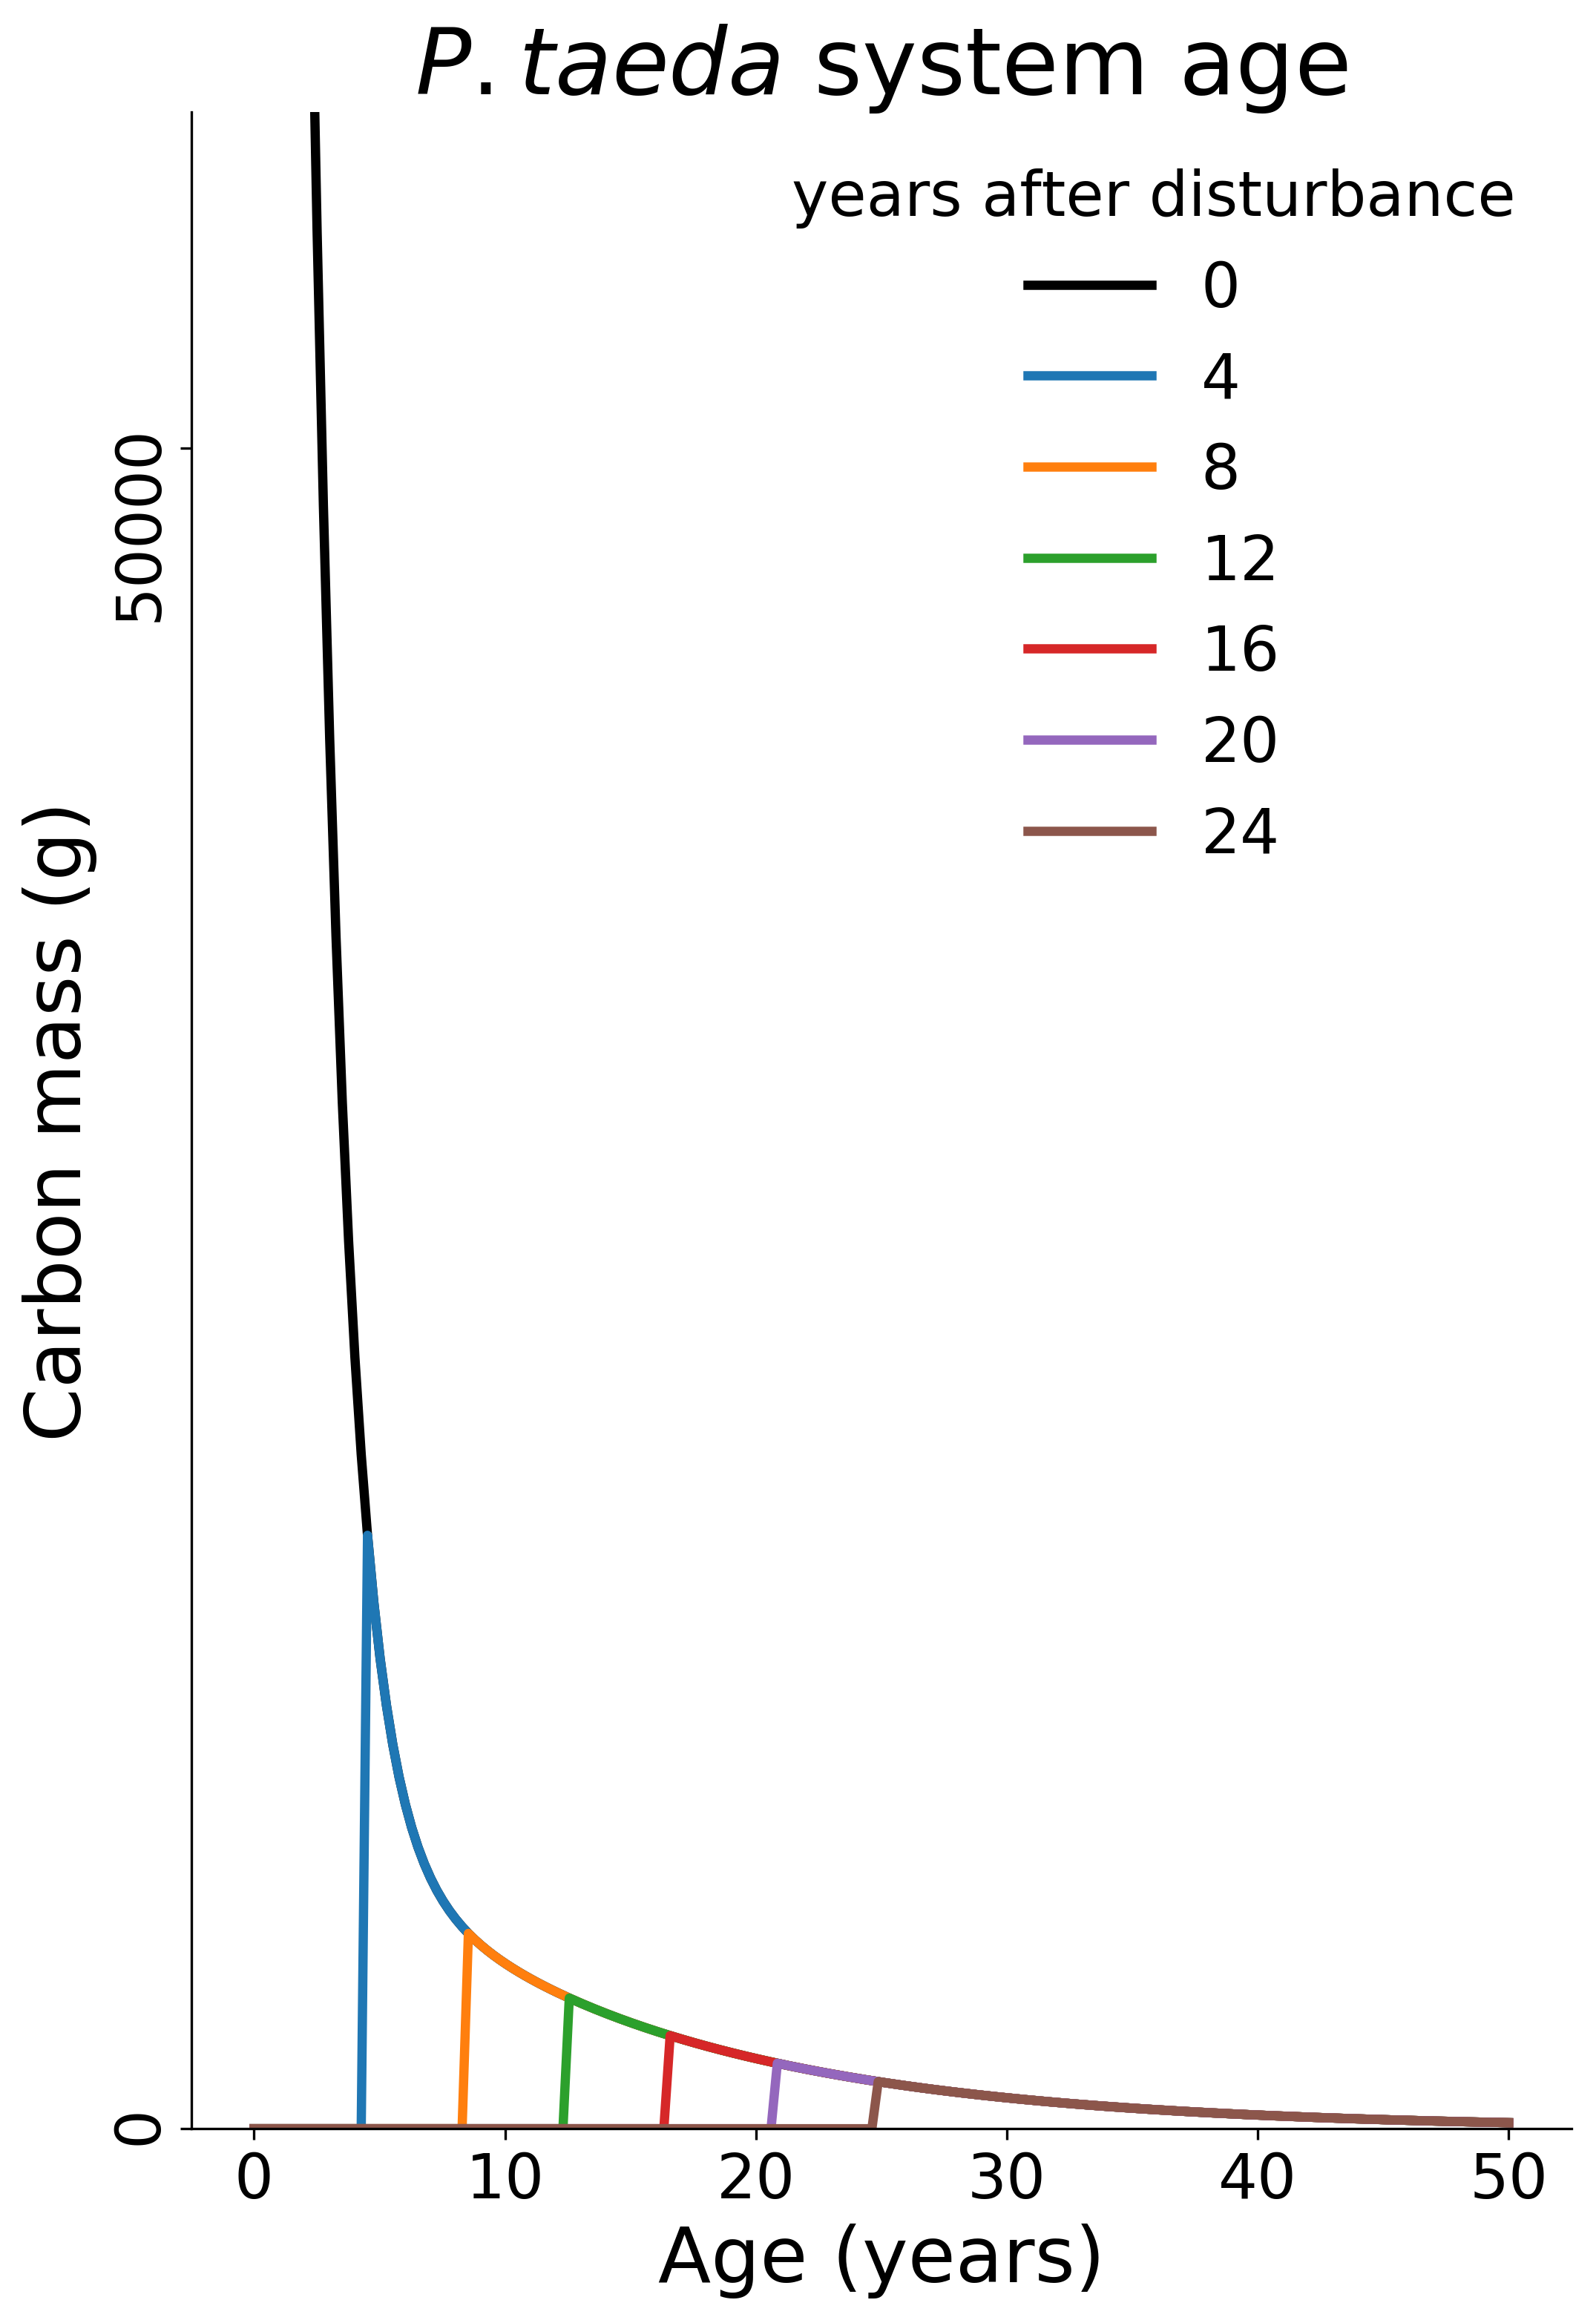

In [9]:
from mpl_toolkits.axisartist.axislines import Subplot
fig=plt.figure(figsize=(8,12), dpi=300)
ax=plt.subplot()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.plot(ages, system_dens_data[:,1], color="black", linewidth=3)
ax.plot(ages, system_dens_data[:,14], color="#1f77b4",linewidth=3)
ax.plot(ages, system_dens_data[:,18], color="#ff7f0e",linewidth=3)
ax.plot(ages, system_dens_data[:,22], color="#2ca02c",linewidth=3)
ax.plot(ages, system_dens_data[:,26], color="#d62728",linewidth=3)
ax.plot(ages, system_dens_data[:,30], color="#9467bd",linewidth=3)
ax.plot(ages, system_dens_data[:,34], color="#8c564b",linewidth=3)
ax.yaxis.set_major_locator(plt.MultipleLocator(50000))
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.yticks(rotation=90)
plt.xlabel('Age (years)', fontsize=25)
plt.ylabel('Carbon mass (g)',fontsize=25)
plt.ylim(0, 60000)
plt.title('$\it{P.taeda}$ system age', fontsize=30)
plt.legend(["0","4", "8","12","16", "20", "24"], 
           title="years after disturbance",
           fontsize=20, 
           title_fontsize=20,
           frameon=False)

plt.savefig('/Users/_dherrera/NSC_ages_and_transit_times/code/P_taeda/P_taeda_sys_age_afterdist.png', dpi=300)
plt.savefig('/Users/_dherrera/NSC_ages_and_transit_times/code/P_taeda/P_taeda_sys_age_afterdist.pdf', dpi=300)

plt.show()

10. We calculated then the backward transit time density (btt_dens) and its mean (btt_moment) for all the years of simulation.

In [10]:
btt_dens= smr.backward_transit_time_density(pool_dens_data)
btt_moment=smr.backward_transit_time_moment(1, start_mean_ages)

In [11]:
btt_moment

array([ 2.40235617,  2.40235617,  2.40235617,  2.40235617,  2.40235617,
        2.40235617,  2.40235617,  2.40235617,  2.40235617,  2.40235617,
        2.51055416,  3.51937746,  5.03261529,  7.08230978,  9.72072912,
       12.71078506, 15.53913755, 17.84389473, 19.62684334, 21.06002538,
       22.29896192, 23.43817922, 24.5269063 , 25.58933579, 26.63727924,
       27.67666642, 28.71063776, 29.74097598, 30.76876941, 31.79472679,
       32.81933328, 33.84293304, 34.86577606, 35.8880468 , 36.90988287,
       37.93138766, 38.95263927, 39.97369697, 40.99460588, 42.01540042,
       43.03610695, 44.05674567, 45.07733209, 46.09787813, 47.118393  ,
       48.13888375, 49.15935587, 50.17981357, 51.20026011, 52.220698  ])

11. We plotted the backward transit time for the trees in steady state (black line, 0 years after disturbance) and the backward transit time for trees after some years of disturbance (4, 8, 12). This is the corresponding plot for P. taeda of the Fig 5 in the manuscript.

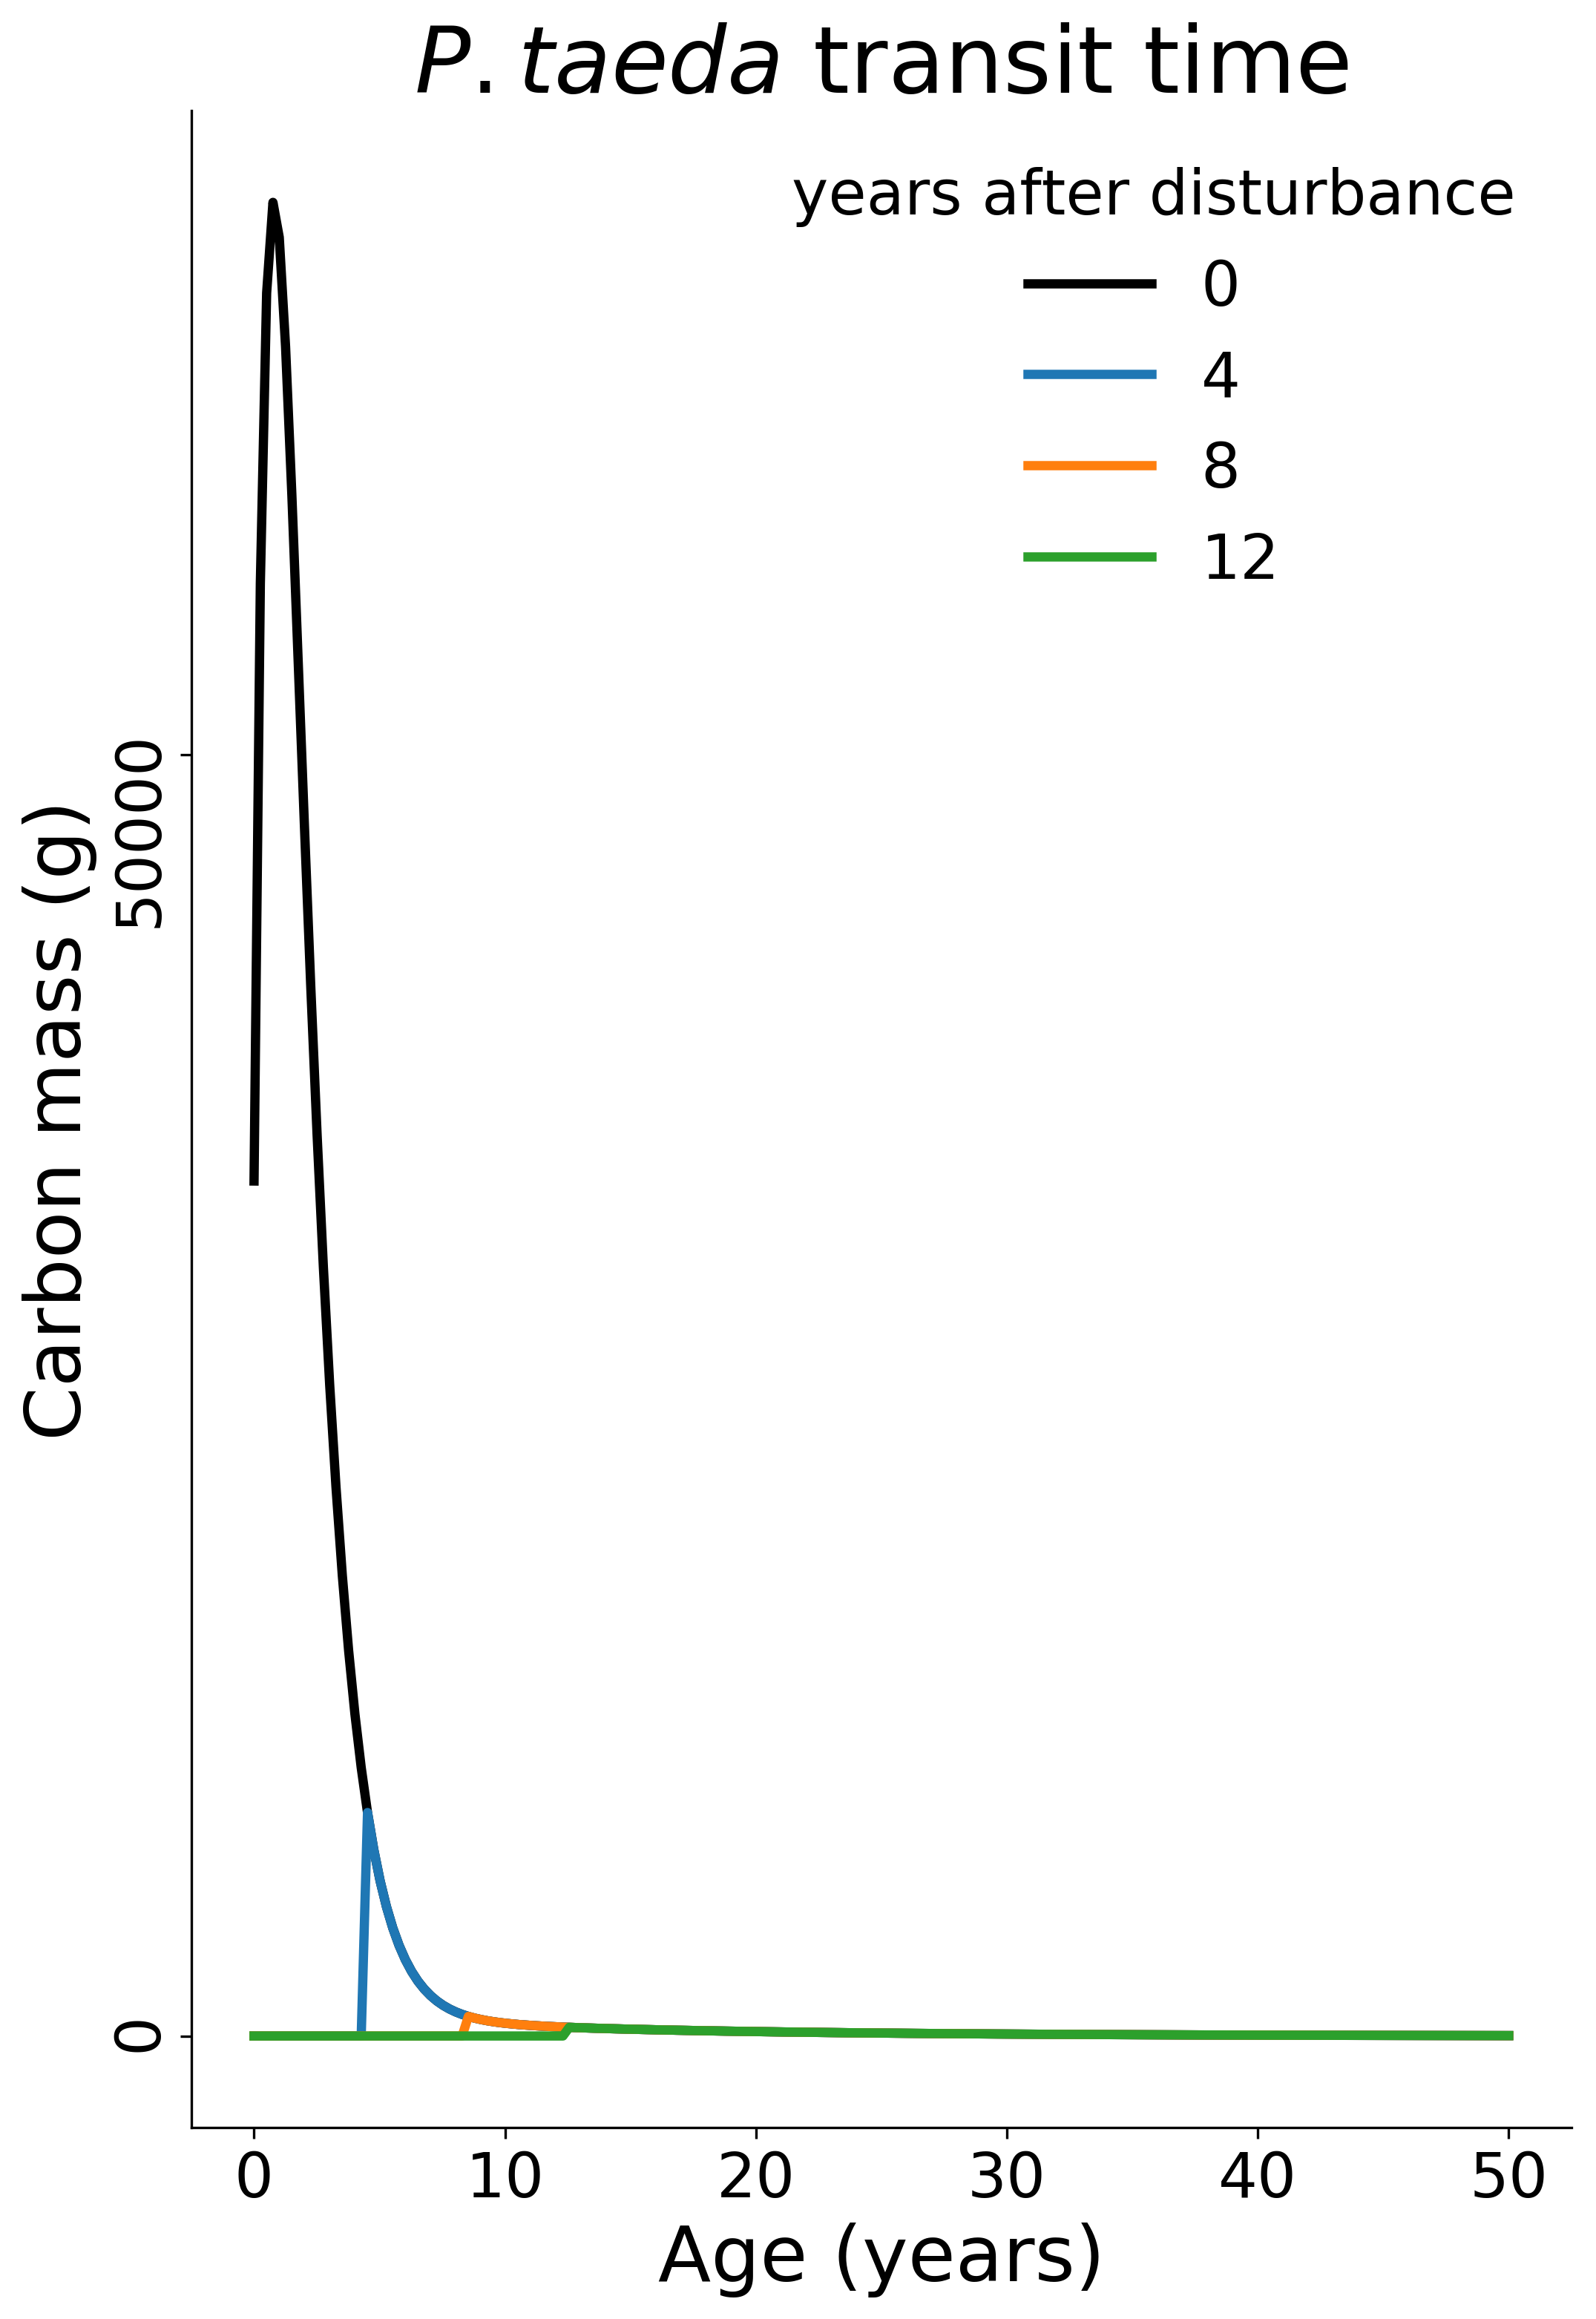

In [12]:
from mpl_toolkits.axisartist.axislines import Subplot
fig=plt.figure(figsize=(8,12), dpi=300)
ax=plt.subplot()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.plot(ages, btt_dens[:,1], color="black", linewidth=3)
ax.plot(ages, btt_dens[:,14], color="#1f77b4",linewidth=3)
ax.plot(ages, btt_dens[:,18], color="#ff7f0e",linewidth=3)
ax.plot(ages, btt_dens[:,22], color="#2ca02c",linewidth=3)
ax.yaxis.set_major_locator(plt.MultipleLocator(50000))
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.yticks(rotation=90)
plt.xlabel('Age (years)', fontsize=25)
plt.ylabel('Carbon mass (g)',fontsize=25)
plt.title('$\it{P.taeda}$ transit time', fontsize=30)
plt.legend(["0","4", "8","12","16", "20", "24"], 
           title="years after disturbance",
           fontsize=20, 
           title_fontsize=20,
           frameon=False)

plt.savefig('/Users/_dherrera/NSC_ages_and_transit_times/code/P_taeda/P_taeda_transit_time_afterdist.png', dpi=300)
plt.savefig('/Users/_dherrera/NSC_ages_and_transit_times/code/P_taeda/P_taeda_transit_time_afterdist.pdf', dpi=300)

plt.show()

12. We computed the amount of carbon contained in each pool for trees in each of the years of simulation. The first 10 years refelct the steady state conditions and the subsequent years show how the carbon content get depleted while the carbon is taken out of the systems. Then we summed the carbon content of all pools to calculate the system carbon contet. 

In [13]:
poolsolution=smr.solve()
systemsolution=np.sum(poolsolution, 1)

In [14]:
systemsolution

array([480687.44518886, 480687.44518886, 480687.44518886, 480687.44518886,
       480687.44518886, 480687.44518886, 480687.44518886, 480687.44518885,
       480687.44518884, 480687.44518882, 440703.66721682, 280061.33935548,
       185993.59198366, 135560.60520355, 108235.98125636,  92190.03910818,
        81536.86780885,  73542.92529217,  66976.78028057,  61283.44398182,
        56203.55544481,  51605.69252429,  47414.46855861,  43580.05774694,
        40065.23256624,  36839.72352449,  33877.64467206,  31156.22358923,
        28655.10630719,  26355.9307843 ,  24242.03632858,  22298.2486586 ,
        20510.71122498,  18866.74724579,  17354.74353512,  15964.0505874 ,
        14684.89528157,  13508.30369337,  12426.03221978,  11430.50568538,
        10514.76142242,   9672.39853691,   8897.53173197,   8184.74917628,
         7529.07399111,   6925.92899358,   6371.10438351,   5860.7281065 ,
         5391.2386508 ,   4959.36006303])

13. The system carbon content is expressed as a fraction 

In [15]:
## relative quantitive of NSC remaining in the system after every time step
Rel_systemsol=(systemsolution/systemsolution[1])*100
Rel_systemsol

array([100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        ,  91.68195917,  58.26266988,
        38.6932494 ,  28.20140334,  22.51691454,  19.17879072,
        16.96255407,  15.29953113,  13.93354059,  12.74912515,
        11.69232856,  10.73581036,   9.86388745,   9.0661943 ,
         8.33498627,   7.66396624,   7.04774901,   6.48159712,
         5.96127621,   5.48296633,   5.04320148,   4.63882485,
         4.2669538 ,   3.92495112,   3.61040084,   3.32108749,
         3.05497791,   2.81020522,   2.58505446,   2.37794971,
         2.18744249,   2.0122012 ,   1.85100148,   1.70271748,
         1.56631384,   1.44083834,   1.32541518,   1.21923886,
         1.12156843,   1.0317224 ])

14. The carbon contetn is expressed as a consumption fraction

In [16]:
## relative amount of carbon consumed by the system after everytime step 
Rel_systemsol2=(Rel_systemsol-100)*-1

15. We built the P. taeda part of the figure 6 in the manuscript. Here we used the mean backward transit time and the consumption fraction of carbon in the NSC system.

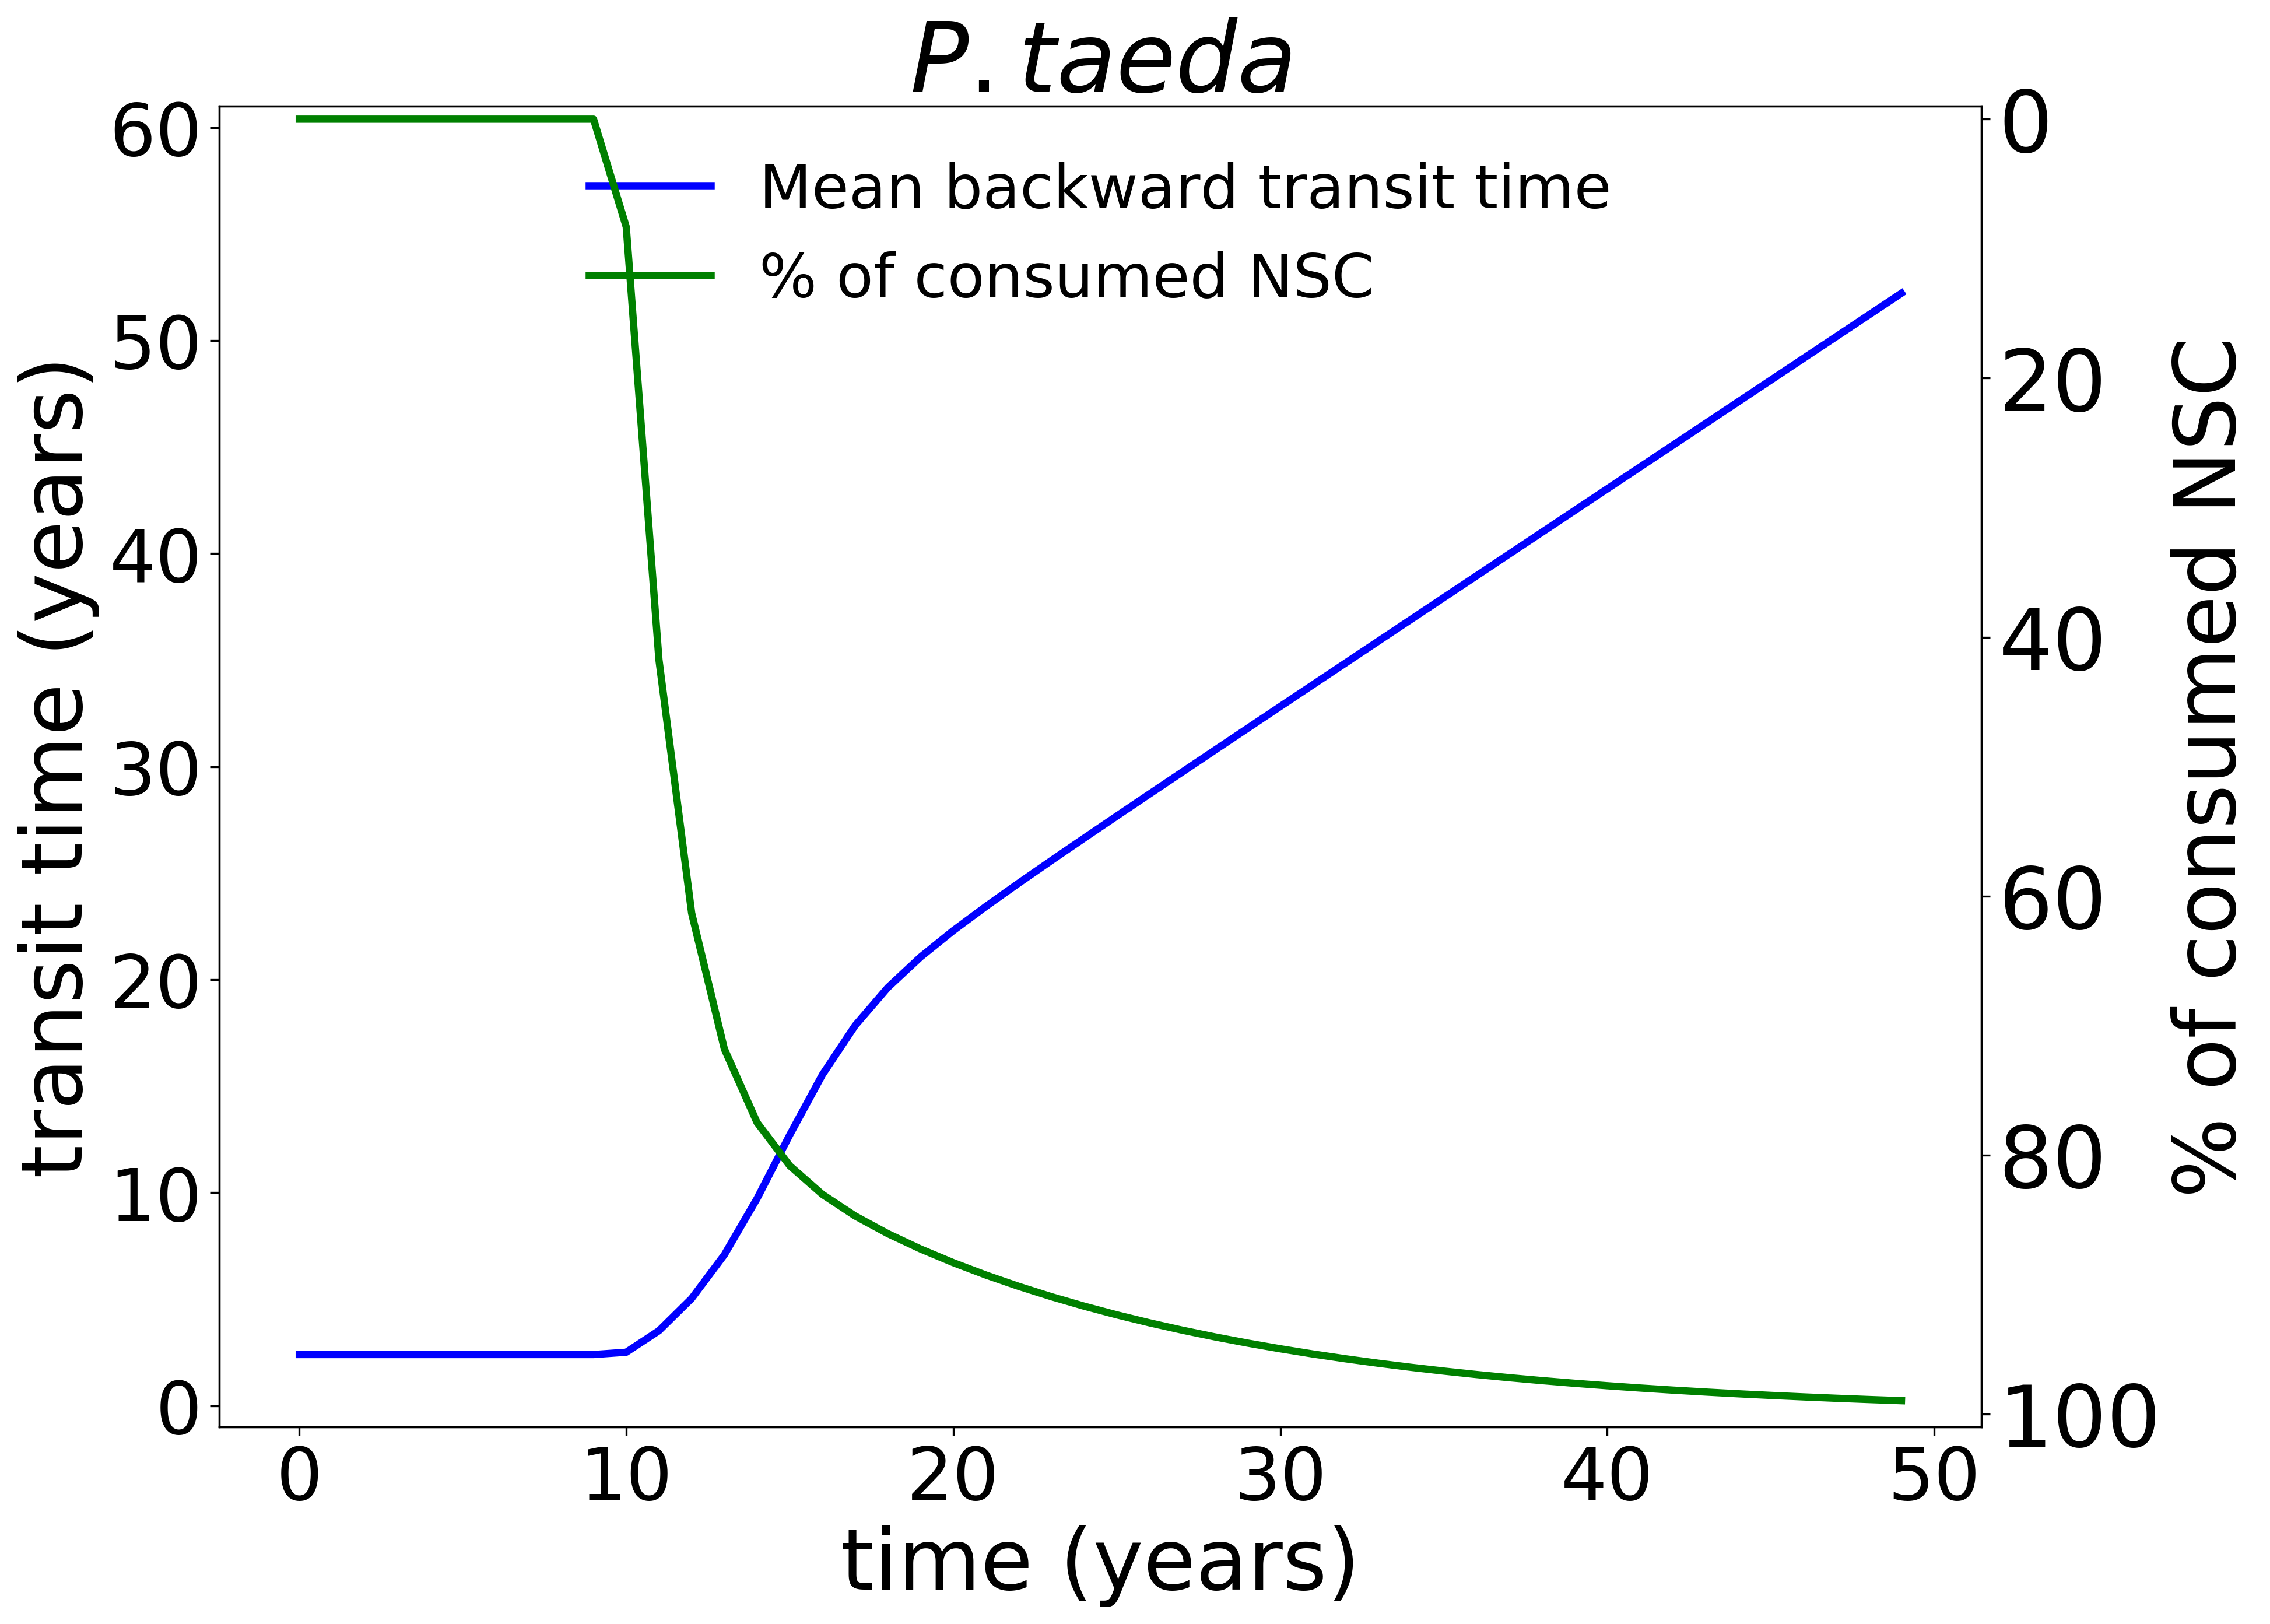

In [17]:
plt.figure(figsize=(13,10), dpi=300)
bttax=plt.subplot()
lns1=bttax.plot(btt_moment, linewidth=3, color="blue", label="Mean backward transit time")
bttax.set_xlabel('time (years)', fontsize=35)
bttax.set_ylabel('transit time (years)',fontsize=35)
bttax.tick_params(labelsize=30)
plt.ylim(-1,61)
bttax2=bttax.twinx()
lns2=bttax2.plot(Rel_systemsol,  linewidth=3, color="green", label="% of consumed NSC")
bttax2.set_ylabel('% of consumed NSC',fontsize=35)
bttax2.tick_params(labelsize=35)
bttax2.yaxis.set_major_formatter(plt.FixedFormatter([100,100,80,60,40,20,0]))
plt.ylim(-1,101)
plt.title('$\it{P. taeda}$', fontsize=40)
lns=lns1+lns2
labs = [l.get_label() for l in lns]
bttax.legend(lns, labs, frameon=False, fontsize=25, loc='upper center')
plt.savefig('/Users/_dherrera/NSC_ages_and_transit_times/code/P_taeda/P_taeda_btt_sol.png', 
            dpi=300,
           bbox_inches='tight')
plt.savefig('/Users/_dherrera/NSC_ages_and_transit_times/code/P_taeda/P_taeda_btt_sol.pdf', 
            dpi=300,
           bbox_inches='tight')

fig.tight_layout()
plt.show()